In [ ]:
!pip install scipy==1.9.3 --force-reinstall

In [34]:
# import scipy
# def derivative(func, x0, dx=1e-6, n=1, order=3):
#     if n != 1 or order != 3:
#         raise NotImplementedError("Only n=1 and order=3 supported")
#     return (func(x0 + dx) - func(x0 - dx)) / (2 * dx)

# scipy.misc.derivative = derivative

import math
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from ADRpy import atmospheres as at
from importlib import reload
import helper_functions
helper_functions = reload(helper_functions)
from helper_functions import *
import specs
specs = reload(specs)
from specs import *
import airfoil_functions
airfoil_functions = reload(airfoil_functions)
from airfoil_functions import *
from airfoils import Airfoil

In [3]:
foil = Airfoil.NACA4('2412')
x,y = foil.all_points

foil_vt = Airfoil.NACA4('0012')
x_vt,y_vt = foil_vt.all_points

In [4]:
# Reynolds_numbers = [calculate_reynolds_number(80, 1, 0), calculate_reynolds_number(150, 1, 2500)]
# deflection_angles = list(range(-15,30,1))  # degrees
# phases = ["takeoff", "cruise"]  # one per Re
# Reynolds_numbers = [calculate_reynolds_number(150, 1, 2500)]
# deflection_angles = [29]  # degrees
# phases = ["cruise"]  # one per Re

# get_airfoil_params_with_flap_effect_naca(
#     airfoil_name="2412",
#     Reynolds_numbers=Reynolds_numbers,
#     deflection_angles=deflection_angles,
#     phases=phases
# )

In [4]:
deflections_dict = {}
deflection_angles = list(range(-15,31,1))  # degrees
phases = ["takeoff", "cruise"]  # one per Re
for def_angle in deflection_angles:
    for phase in phases:

        deflections_dict[f"{phase}_{def_angle}"] = load_xfoil_polar(f'ht_deflections/NACA2412_def ({def_angle} deg)_{phase}.plr')


In [5]:
# airfoil_coeffs_vs_alpha = load_xfoil_polar(f'NACA 2412-{int(calculate_reynolds_number(200, 1, 3000))}.dat')
# airfoil_coeffs_vs_alpha_to = load_xfoil_polar(f'NACA 2412-{int(calculate_reynolds_number(80, 1, 0))}.dat')
airfoil_coeffs_vs_alpha_vt = load_xfoil_polar(f'NACA 0012-{int(calculate_reynolds_number(200, 1, 3000))}.dat')



In [6]:

# cruise_trim_analysis(current_values["neutral_point_m"], current_values["cruiseout_cg_from_nose_m"], 
#                                                 current_values["cruiseout_cl"], current_values["tail_arm_m"], eta_h, cruiseout_delt_cl_from_thrust, current_values["cruiseout_angle_of_attack_deg"], "cruiseout")



# def cruise_trim_analysis(
#     neutral_point_m,
#     cg_from_nose,
#     cl_cruise,
#     tail_arm_m,
#     eta_h,
#     delta_cl_from_thrust,
#     current_angle_of_attack,
#     phase
# ):

def cruise_trim_analysis(current_values, assumed_and_set, hard_constraints, phase):
    
    
    rho = get_air_density(hard_constraints["cruise_altitude_m"])
    v_ms = kmh_to_ms(current_values[f"{phase}_speed_kmh"])
    q = 0.5 * rho * v_ms**2
    
    phase_for_delta = ""
    if ("cruise" in phase) or (phase == "loiter"):
        phase_for_delta = "cruise"
    elif phase in ["takeoff", "landing"]:
        phase_for_delta = "takeoff"

    dict_of_aero_coeffs_vs_deflections_at_alpha = {}
    effective_angle_of_attack = current_values[f"{phase}_angle_of_attack_deg"] * (1-assumed_and_set['ht_downwash_efficiency_coeff']) + assumed_and_set["ht_incident_angle"]
    for deg in range(-15,31,1):
        try:
            dict_of_aero_coeffs_vs_deflections_at_alpha[str(deg)] = get_coefficients_at_alpha(deflections_dict[f"{phase_for_delta}_{deg}"], effective_angle_of_attack)
        except Exception as e:
            print(deg, "---", e)

    delta_vs_alpha_frame = pd.DataFrame(dict_of_aero_coeffs_vs_deflections_at_alpha).T
    delta_vs_alpha_frame["alpha"] = delta_vs_alpha_frame.index.astype(int)
    
    delta_cl_from_thrust = get_delt_cl_from_thrust(current_values, hard_constraints, phase)
    
    # print("thrust: ",delta_cl_from_thrust)
    wing_cl_to_counter = ((current_values[f"{phase}_cg_from_nose_m"] - current_values["neutral_point_m"]) * (current_values["wing_area_m2"]/current_values["horizontal_tail_area_m2"]) * current_values[f"{phase}_cl"] / current_values["tail_arm_m"])
    
    # print("wing: ", wing_cl_to_counter)
    required_cl_tail = wing_cl_to_counter + delta_cl_from_thrust

    
    ht_deflection_angle = get_row_for_cl(delta_vs_alpha_frame, required_cl_tail)["alpha"]
    
    
    return {
        "cl_tail_required": required_cl_tail,
        "delta_elevator_deg": ht_deflection_angle,
    }



In [40]:
def relax(old, new, lam=0.25):
    return (1.0 - lam)*old + lam*new



def key_error(curr, prev, key, target_error, eps=1e-9):

    
    ABS_TOL = {
        "cruiseout_static_margin":   target_error/10,
        "loiter_static_margin":      target_error/10,
        "cruiseback_static_margin":  target_error/10,   # << key fix
        "cruiseout_cl":              target_error/100,
        "loiter_cl":                 target_error/100,
        "cruiseback_cl":             target_error/100,
        # add more if needed
    }
    REL_TOL = target_error  # 2% for most quantities

    # hybrid: absolute OR relative

    
    abs_err = abs(curr - prev)
    rel_den = max(abs(prev), eps)#, 1.0 if key.endswith("_static_margin") else eps)
    rel_err = abs_err / rel_den
    # accept if either test passes
    # if key in ABS_TOL:
    #     return abs_err
    # else:
    return rel_err
    
def aitken(x0,x1,x2):

    if (x1 - x0)*(x2 - x1) >= 0:
        return relax(x1, x2, 0.1)
    
    num = (x2-x1)**2
    den = x2- 2*x1 + x0

    x_aitken = x2 - num/(den if den != 0 else 1e-9)
        
    return x_aitken

def aitken_safe(x0, x1, x2, eps=1e-12, max_step_frac=0.20):
    den = x2 - 2.0*x1 + x0
    # Only accelerate if we see alternation (two-cycle signature)
    if (x1 - x0)*(x2 - x1) >= 0.0 or abs(den) < eps:
        return x2
    x_acc = x2 - (x2 - x1)**2 / den
    # clamp the extrapolated jump
    cap = max_step_frac * max(abs(x2), 1e-9)
    dx  = max(-cap, min(cap, x_acc - x2))
    return x2 + dx
    

In [43]:
def refine_design_from_iterable_constraints(
    hard_constraints, assumed_and_set, weights_dict_kg_no_fuel,
    iterable_constraints, deflections_dict,
    target_error=0.02, max_iterations=10
):
    g = 9.81
    cur  = iterable_constraints.copy()
    prev = iterable_constraints.copy()
    aitken_values = iterable_constraints.copy()

    cl_max_values = effective_CLmax_partial_span(   deflections_dict,assumed_and_set,
                                                    phase_prefix="takeoff", alpha_margin_deg=0.0              # optional: back off a little from the formal max if desired
                                                )
    
    for i in range(max_iterations):
        # ------------------------------
        # 0) Atmosphere & phase speeds
        # ------------------------------
        rho   = get_air_density(hard_constraints["cruise_altitude_m"])
        Vc_ms = kmh_to_ms(cur["cruiseout_speed_kmh"])
        Vl_ms = kmh_to_ms(cur["loiter_speed_kmh"])
        Vb_ms = kmh_to_ms(cur["cruiseback_speed_kmh"])

        # ---------------------------------------------------------
        # 1) GEOMETRY (wing/tail/fuselage) — fuselage sizing FIRST
        # ---------------------------------------------------------
        # Wing geometry (use the current wing area; will be refreshed at end of iter)
        
        cur["wing_span_m"] = np.sqrt(cur["wing_area_m2"] * assumed_and_set["aspect_ratio"])
        cur["chord_m"]     = cur["wing_area_m2"] / cur["wing_span_m"]

        # Geometric tail arm (fixed AC→AC; do NOT tie to moving wing AC)
        cur["tail_arm_m"] = assumed_and_set["horizontal_tail_arm_mac_coeff"] * cur["chord_m"]
        

        # Fuselage main length from your sizing model (do this BEFORE masses & CGs)
        cur["fuselage_body_length_m"] = initial_size_fuselage(hard_constraints, assumed_and_set, cur, False)
        # 
        

        # Wing LE station as a fraction of fuselage length (geometry placement)
        cur["wing_le_position_m"] = assumed_and_set["wing_le_position_fuselage_length_coeff"] * cur["fuselage_body_length_m"]

        # cur["tail_arm_m"] = cur["fuselage_body_length_m"] * 0.9 - (cur['wing_le_position_m'] + 0.25*cur["chord_m"])

        # Tail areas from volume coefficients (use current tail arm)
        cur["horizontal_tail_area_m2"] = (
            assumed_and_set["horizontal_tail_volume_coefficient"]
            * (cur["wing_area_m2"] * cur["chord_m"]) / cur["tail_arm_m"]
        )
        cur["vertical_tail_area_m2"] = (
            assumed_and_set["vertical_tail_volume_coefficient"]
            * (cur["wing_area_m2"] * cur["wing_span_m"]) / cur["tail_arm_m"]
        )

        # Tail planform geometry from areas + AR
        cur["h_tail_span_m"], cur["h_tail_chord_m"] = tail_geometry(cur["horizontal_tail_area_m2"], assumed_and_set["AR_horizontal"])
        cur["v_tail_span_m"], cur["v_tail_chord_m"] = tail_geometry(cur["vertical_tail_area_m2"],   assumed_and_set["AR_vertical"])

        cur["x_ht_le_m"] = cur["wing_le_position_m"] + 0.25*cur["chord_m"] + cur["tail_arm_m"] - 0.25*cur["h_tail_chord_m"]
        # -----------------------------------------
        # 2) STRUCTURAL MASSES (per-item components)
        # -----------------------------------------
        # Fuselage mass (depends on sized fuselage geometry)
        fuselage_mass = get_fuselage_mass(
            cur["fuselage_body_length_m"],
            cur["fuselage_body_width_m"],
            cur["fuselage_body_height_m"],
            assumed_and_set
        ) * assumed_and_set["fuselage_internal_supports_mass_multiplier"] + assumed_and_set["paint_density"] * cur["fuselage_body_length_m"] * 2 * (cur["fuselage_body_height_m"] + cur["fuselage_body_width_m"])

        weights_dict_kg_no_fuel["fuselage"] = fuselage_mass

        # Wing mass via perimeter*span method
        # wing_perimeter = airfoil_perimeter_length(x, y, cur["chord_m"])
        # wing_mass = get_wing_or_tail_mass(
        #     cur["wing_span_m"], wing_perimeter, "wing", assumed_and_set
        # ) * assumed_and_set["wing_internal_supports_mass_multiplier"]
        
        wing_mass = get_wing_or_tail_mass(
            cur["wing_area_m2"], assumed_and_set, "wing"
        ) * assumed_and_set["wing_internal_supports_mass_multiplier"] + assumed_and_set["paint_density"]*(2*cur["wing_area_m2"])

        weights_dict_kg_no_fuel["wing"] = wing_mass

        # Horizontal tail mass
        # htail_perimeter = airfoil_perimeter_length(x, y, cur["h_tail_chord_m"])
        # htail_mass = get_wing_or_tail_mass(
        #     cur["h_tail_span_m"], htail_perimeter, "tail", assumed_and_set
        # ) * assumed_and_set["tail_internal_supports_mass_multiplier"]

        htail_mass = get_wing_or_tail_mass(
            cur["horizontal_tail_area_m2"], assumed_and_set, "tail"
        ) * assumed_and_set["tail_internal_supports_mass_multiplier"] + assumed_and_set["paint_density"]*(2*cur["horizontal_tail_area_m2"])

        # Vertical tail mass
        # vtail_perimeter = airfoil_perimeter_length(x_vt, y_vt, cur["v_tail_chord_m"])
        # vtail_mass = get_wing_or_tail_mass(
        #     cur["v_tail_span_m"], vtail_perimeter, "tail", assumed_and_set
        # ) * assumed_and_set["tail_internal_supports_mass_multiplier"]

        vtail_mass = get_wing_or_tail_mass(
            cur["vertical_tail_area_m2"], assumed_and_set, "tail"
        ) * assumed_and_set["tail_internal_supports_mass_multiplier"] + assumed_and_set["paint_density"]*(2*cur["vertical_tail_area_m2"])

        weights_dict_kg_no_fuel["horizontal_tail"] = htail_mass
        weights_dict_kg_no_fuel["vertical_tail"]   = vtail_mass
        weights_dict_kg_no_fuel["tails"]           = htail_mass + vtail_mass  # if you still use a combined key

        # ------------------------------------------------
        # 3) FUEL CAPACITY & DISTRIBUTION (by geometry)
        # ------------------------------------------------
        # Fuselage tank capacity from sized cross-section and your tank length
        fus_cs_area = (
            (cur["fuselage_body_width_m"]  - 2*sandwich_specs["fuselage"]["total_thickness_m"] - 0.02) *
            (cur["fuselage_body_height_m"] - 2*sandwich_specs["fuselage"]["total_thickness_m"] - 0.02)
        )
        fus_tank_vol_m3 = assumed_and_set["fuselage_fuel_tank_length"] * fus_cs_area
        fus_tank_cap_kg = fus_tank_vol_m3 * 1000.0 * assumed_and_set["fuel_density_kgL"]

        # Wing tank capacity from your helper (uses current wing geometry)
        wing_tank_vol_m3 = wing_fuel_tank_volume("naca2412_coords.dat", cur, 0.25, 0.65)

        # Fuel from previous iteration (or initial seed)
        fuel_total = cur.get("fuel_kg", 0.0)

        # Split: fill fuselage first, rest to wing
        fus_fuel_kg  = min(fuel_total, fus_tank_cap_kg)
        wing_fuel_kg = max(0.0, fuel_total - fus_fuel_kg)

        # ------------------------------------------
        # 4) COMPONENT POSITIONS (for CG calculation)
        # ------------------------------------------
        comp_x, comp_z = estimate_component_positions(cur, hard_constraints, assumed_and_set, weights_dict_kg_no_fuel)

        # ==========================================
        # 5) PHASES (CG → NP → TRIM → DRAG/POWER)
        # ==========================================

        # ---------- CRUISE OUT ----------
        wts_c = weights_dict_kg_no_fuel.copy()
        wts_c["fuselage_fuel"] = fus_fuel_kg
        wts_c["wing_fuel"]     = wing_fuel_kg
        cur["cruiseout_mass_kg"] = sum(wts_c.values())

        cur["cruiseout_cg_from_nose_m"]  = calculate_cg(wts_c, comp_x)
        cur["cruiseout_cg_from_floor_m"] = calculate_cg(wts_c, comp_z)

        stab_c = stability_analysis(cur, assumed_and_set, deflections_dict, "cruiseout")
        cur["neutral_point_m"]         = stab_c["neutral_point_m"]
        cur["cruiseout_static_margin"] = stab_c["static_margin"]

        trim_c = closed_form_trim_analysis(cur, assumed_and_set, hard_constraints, deflections_dict, "cruiseout")
        # phase = "cruiseout"
        # trim_c = solve_phase_trim(cur, assumed_and_set, hard_constraints, deflections_dict, phase, weights_dict_kg_no_fuel)
        cur["cruiseout_cl"]                 = trim_c["cl_wing"]
        cur["cruiseout_angle_of_attack_deg"]= trim_c["alpha_wing_deg"]
        cur["cruiseout_cl_tail_required"]   = trim_c["cl_tail_required"]
        cur["cruiseout_delta_elevator_deg"] = trim_c["delta_elevator_deg"]

        Cd0_sec = get_row_for_cl(deflections_dict["cruise_0"], 0)["CD"]  # section CD at CL≈0 for parasite baseline
        cur["cruiseout_cd_tail"] = calc_cd_total(Cd0_sec, cur["cruiseout_cl_tail_required"], assumed_and_set["AR_horizontal"], e=assumed_and_set["oswald_clean"])
        cur["cruiseout_cd"]      = calc_cd_total(Cd0_sec, cur["cruiseout_cl"],              assumed_and_set["aspect_ratio"], e=assumed_and_set["oswald_clean"])

        D_c = 0.5*rho*Vc_ms**2 * (cur["wing_area_m2"]*cur["cruiseout_cd"] + cur["horizontal_tail_area_m2"]*cur["cruiseout_cd_tail"])
        P_c = D_c * Vc_ms / (propeller_specs["efficiency"]["cruise"] * engine_specs["gear_box_efficiency"]) / 1000.0
        cur["cruiseout_power_kw"] = P_c

        sfc_c = estimate_cruise_sfc_from_dicts(engine_power_to_rpm, engine_sfc_to_rpm, P_c)
        cur["cruiseout_sfc"] = sfc_c["sfc_cruise"]
        cur["cruiseout_rpm"] = sfc_c["rpm_cruise"]
        cur["cruiseout_time"]= hard_constraints["target_station_distance_km"] / cur["cruiseout_speed_kmh"]
        fuel_c = P_c * cur["cruiseout_time"] * cur["cruiseout_sfc"]

        # ---------- LOITER ----------
        fus_fuel_l  = max(0.0, fus_fuel_kg - fuel_c)  # burn from fuselage first per your scheme
        wing_fuel_l = wing_fuel_kg

        wts_l = weights_dict_kg_no_fuel.copy()
        wts_l["fuselage_fuel"] = fus_fuel_l
        wts_l["wing_fuel"]     = wing_fuel_l
        cur["loiter_mass_kg"] = sum(wts_l.values())

        cur["loiter_cg_from_nose_m"]  = calculate_cg(wts_l, comp_x)
        cur["loiter_cg_from_floor_m"] = calculate_cg(wts_l, comp_z)

        stab_l = stability_analysis(cur, assumed_and_set, deflections_dict, "loiter")
        cur["loiter_static_margin"] = stab_l["static_margin"]

        trim_l = closed_form_trim_analysis(cur, assumed_and_set, hard_constraints, deflections_dict, "loiter")
        # phase = "loiter"
        # trim_l = solve_phase_trim(cur, assumed_and_set, hard_constraints, deflections_dict, phase, weights_dict_kg_no_fuel)
        cur["loiter_cl"]                 = trim_l["cl_wing"]
        cur["loiter_angle_of_attack_deg"]= trim_l["alpha_wing_deg"]
        cur["loiter_cl_tail_required"]   = trim_l["cl_tail_required"]
        cur["loiter_delta_elevator_deg"] = trim_l["delta_elevator_deg"]
        
        cur["loiter_cd_tail"] = calc_cd_total(Cd0_sec, cur["loiter_cl_tail_required"], assumed_and_set["AR_horizontal"], e=assumed_and_set["oswald_clean"])
        cur["loiter_cd"]      = calc_cd_total(Cd0_sec, cur["loiter_cl"],              assumed_and_set["aspect_ratio"], e=assumed_and_set["oswald_clean"])

        D_l = 0.5*rho*Vl_ms**2 * (cur["wing_area_m2"]*cur["loiter_cd"] + cur["horizontal_tail_area_m2"]*cur["loiter_cd_tail"])
        P_l = D_l * Vl_ms / (propeller_specs["efficiency"]["cruise"] * engine_specs["gear_box_efficiency"]) / 1000.0
        cur["loiter_power_kw"] = P_l

        sfc_l = estimate_cruise_sfc_from_dicts(engine_power_to_rpm, engine_sfc_to_rpm, P_l)
        cur["loiter_sfc"] = sfc_l["sfc_cruise"]
        cur["loiter_rpm"] = sfc_l["rpm_cruise"]
        fuel_l = P_l * hard_constraints["loiter_time"] * 1.1 * cur["loiter_sfc"]  # keep your 1.1 margin if desired

        # ---------- CRUISE BACK ----------
        fus_fuel_b  = max(0.0, fus_fuel_l - fuel_l)
        wing_fuel_b = wing_fuel_l  # adjust policy if you also burn wing fuel here

        wts_b = weights_dict_kg_no_fuel.copy()
        wts_b["fuselage_fuel"]  = fus_fuel_b
        wts_b["wing_fuel"]      = wing_fuel_b
        wts_b["internal_payload"] = 0
        wts_b["wing_payload"]     = 0
        cur['cruiseback_mass_kg'] = sum(wts_b.values())

        cur["cruiseback_cg_from_nose_m"]  = calculate_cg(wts_b, comp_x)
        cur["cruiseback_cg_from_floor_m"] = calculate_cg(wts_b, comp_z)

        stab_b = stability_analysis(cur, assumed_and_set, deflections_dict, "cruiseback")
        cur["cruiseback_static_margin"] = stab_b["static_margin"]

        

        trim_b = closed_form_trim_analysis(cur, assumed_and_set, hard_constraints, deflections_dict, "cruiseback")
        # phase = "cruiseback"
        # trim_b = solve_phase_trim(cur, assumed_and_set, hard_constraints, deflections_dict, phase, weights_dict_kg_no_fuel)
        cur["cruiseback_cl"]                 = trim_b["cl_wing"]
        cur["cruiseback_angle_of_attack_deg"]= trim_b["alpha_wing_deg"]
        cur["cruiseback_cl_tail_required"]   = trim_b["cl_tail_required"]
        cur["cruiseback_delta_elevator_deg"] = trim_b["delta_elevator_deg"]

        cur["cruiseback_cd_tail"] = calc_cd_total(Cd0_sec, cur["cruiseback_cl_tail_required"], assumed_and_set["AR_horizontal"], e=assumed_and_set["oswald_clean"])
        cur["cruiseback_cd"]      = calc_cd_total(Cd0_sec, cur["cruiseback_cl"],              assumed_and_set["aspect_ratio"], e=assumed_and_set["oswald_clean"])

        D_b = 0.5*rho*Vb_ms**2 * (cur["wing_area_m2"]*cur["cruiseback_cd"] + cur["horizontal_tail_area_m2"]*cur["cruiseback_cd_tail"])
        P_b = D_b * Vb_ms / (propeller_specs["efficiency"]["cruise"] * engine_specs["gear_box_efficiency"]) / 1000.0
        cur["cruiseback_power_kw"] = P_b

        sfc_b = estimate_cruise_sfc_from_dicts(engine_power_to_rpm, engine_sfc_to_rpm, P_b)
        cur["cruiseback_sfc"] = sfc_b["sfc_cruise"]
        cur["cruiseback_rpm"] = sfc_b["rpm_cruise"]
        cur["cruiseback_time"]= hard_constraints["target_station_distance_km"] / cur["cruiseback_speed_kmh"]
        fuel_b = P_b * cur["cruiseback_time"] * cur["cruiseback_sfc"]

        # ---------------------------------------------
        # 6) TOTAL FUEL / MTOW and CAPACITY CHECKS
        # ---------------------------------------------
        cur["fuel_kg"] = fuel_c + fuel_l + fuel_b
        cur["mtow"]    = sum(wts_c.values())
        # print(wts_c)
        # Volume check after refreshed fuel
        cur["required_fuel_volume_m3"]    = cur["fuel_kg"] / assumed_and_set["fuel_density_kgL"] / 1000.0
        cur["space_available_for_fuel_m3"]= fus_tank_vol_m3 + wing_tank_vol_m3

        # ---------------------------------------------
        # 7) OPTIONAL: REFRESH WING AREA (design var)
        # ---------------------------------------------

        wing_area_from_stall = wing_area_from_stall_speed(
                                                        cur, hard_constraints, deflections_dict, assumed_and_set,
                                                        alpha_margin_deg=0.0, altitude_m=0.0
                                                    )["wing_area_m2"]
        
        wing_area_from_ground_run = wing_area_from_takeoff_distance(
                                                    cur, assumed_and_set, hard_constraints,
                                                    engine_specs, propeller_specs, deflections_dict,
                                                    thrust_static_cap_factor=1.1,   # caps T ~ factor * (Pavail / V_LOF)
                                                    altitude_m=0.0,
                                                    max_iter=40, tol=0.5
                                                )["wing_area_m2"]

        cur["wing_area_m2"]   = max(wing_area_from_stall, wing_area_from_ground_run)
        cur["wing_span_m"]    = np.sqrt(cur["wing_area_m2"] * assumed_and_set["aspect_ratio"])
        cur["chord_m"]        = cur["wing_area_m2"] / cur["wing_span_m"]
        cur["wing_loading_pa"]= cur["mtow"] * g / cur["wing_area_m2"]
        cur['high_wing_offset_m'] = (cur['fuselage_body_height_m']/2) - cur["chord_m"]*assumed_and_set['wing_airfoil_thickness_ratio']

        # ---------------------------------------------
        # 8) CONVERGENCE (focus on critical scalars)
        # ---------------------------------------------

        for key in cur:
            
            # cur[key] = relax(prev[key], cur[key], lam=1.1)
            

            # if key_rel_error > target_error:
            cur[key] = aitken(aitken_values[key], prev[key], cur[key])
            
           
        rel_err = {k: key_error(cur[k], prev[k], k, target_error) for k in cur}
        
        aitken_values.update(prev)
        prev.update(cur)

        # print(trim_b)
        print(cur["wing_area_m2"])

        if all(err < target_error for err in rel_err.values()):
            if cur["required_fuel_volume_m3"] > cur["space_available_for_fuel_m3"]:
                print(f"❌ Fuel volume short: need {cur['required_fuel_volume_m3']:.5f} m³, have {cur['space_available_for_fuel_m3']:.5f} m³.")
            else:
                print(f"Converged in {i+1} iterations.")

             
            return cur

    worst_key = max(rel_err, key=rel_err.get)
    worst_val = rel_err[worst_key]
    print(f"Completed iterations without convergence. Max error: {worst_val} in {worst_key}")    

    return cur


In [46]:

assumed_and_set = {
    # Mission requirements
    "rolling_resistance_coefficient": 0.04, # dimensionless   
    "flap_deflection_deg": 20,
    "flap_retraction_step_count": 2,
    "flap_span_fraction": 0.5,
    "spanwise_flap_effectiveness": 0.9,
    "takeoff_cl_fraction_from_max" : 0.8,
    "target_drop_altitude_m": 2500,
    "sea_level_air_density": get_air_density(0),
    "horizontal_tail_volume_coefficient": 0.65, # dimensionless
    "vertical_tail_volume_coefficient": 0.04, # Computed Vv
    "horizontal_tail_arm_mac_coeff": 3.5, # dimensionless
    "horizontal_tail_arm_fuselage_coeff": 0.9,
    "tail_mass_cg_from_le_coeff": 0.35,
    "ht_downwash_efficiency_coeff": 0.3,
    # "fuselage_length_mac_coeff": 5, # dimensionless
    "wing_le_position_fuselage_length_coeff": 0.35, # dimensionless
    # Configuration
    "fuel_density_kgL": 0.74,
    "gfrp_thickness_m": 0.0015, # meters
    "gfrp_density_kgm3": 2150, # kg/m^3
    "core_density_kgm3": 60,
    "fuselage_fuel_tank_length": 0.55, #meters
    "fuselage_internal_supports_mass_multiplier": 1.3,
    "wing_internal_supports_mass_multiplier": 1.3,
    "tail_internal_supports_mass_multiplier": 1.1,
    "aspect_ratio": 10  , # starting assumption
    "AR_horizontal": 4.0,                # aspect ratio of horizontal tail
    "AR_vertical": 2.0,                  # aspect ratio of vertical tail
    # "cl_alpha" : 8.44, # cl / angle of attack slope in (rad). taken from airfoil data
    "loiter_drag_multiplier": 1.05, ## assumes 5% extra drag due to turns, lower speed, and loss of energy
    "dihedral_deg": 0.0,                        # Wing dihedral angle (degrees)
    "wing_sweep_deg": 0.0,                      # Wing sweep at 25% chord (degrees)
    "wing_incident_angle" : 0,                  ## degrees
    "ht_incident_angle": 0,                    ## degrees
    # "high_wing_offset_m": 0.15,                  # Vertical distance from fuselage centerline to wing root (m)
    "elevator_chord_fraction": 0.35,            # Fraction of HT chord used for elevator
    "elevator_effectiveness_tau": 0.45,           # Rudder hinge efficiency (0.3–0.6 typical)  
    "rudder_chord_fraction": 0.35,              # Fraction of VT chord used for rudder
    "rudder_effectiveness_tau": 0.45,           # Rudder hinge efficiency (0.3–0.6 typical)    
    "wing_airfoil_thickness_ratio": 0.12, # Wing airfoil thickness ratio (12% for NACA 2412) same used for horizontal tail
    "vertical_tail_airfoil_thickness_ratio": 0.12, # Wing airfoil thickness ratio (12% for NACA 0012)
    "paint_density": 0.3, # kg/m^2
    "oswald_clean" : 0.8,
    "oswald_derated": 0.65,

    }

hard_constraints = {
    "wing_payload_mass" : 100, # kg
    "internal_payload_mass": 100, #kg
    "internal_payload_length": 1.3, # meter
    "target_station_distance_km": 200,
    "loiter_time": 3, # hours
    "takeoff_distance_max_m": 200, # dirt road
    "climb_time_min": 13, # minutes
    "cruise_altitude_m": 3000,  
    "stall_speed_kmh": 100,
}

weights_dict_kg_no_fuel = {
    "fuselage": 120,
    "wing": 350,
    "tails": 20,
    "internal_payload": hard_constraints["internal_payload_mass"],
    "wing_payload": hard_constraints["wing_payload_mass"],
    "engine": engine_specs["dry_weight_kg"],
    "propeller": propeller_specs["weight_kg"],
    "avionics": 10,
    "landing_gear": 20,
    "misc": 10,
}

iterable_constraints = {
 'wing_area_m2': 6.893312685402619,
 'wing_loading_pa': 641.4331848036059,
 'wing_span_m': 9.823765957902125,
 'chord_m': 0.7016975684215804,
 'neutral_point_m': 2.236884842540574,
 'wing_le_position_m': 1.9568148328423587,
 'rudder_area_m2': 0.0,
 'elevator_area_m2': 0.0,
 'fuselage_body_length_m': 4.8920370821058965,
 'fuselage_body_width_m': 0.62,
 'fuselage_body_height_m': 0.45,
 'fuselage_tail_arm_extension_m': 0,
 'high_wing_offset_m': 0.15,
 'space_available_for_fuel_m3': 0.1549860517871871,
 'tail_arm_m': 2.2598882898635804,
 'tail_boom_pylon_height_m': 0.25,
 'horizontal_tail_area_m2': 0.7491331629064836,
 'h_tail_chord_m': 0.43276239523163385,
 'h_tail_span_m': 1.7310495809265356,
 'x_ht_le_m': 4.294642771623806,
 'vertical_tail_area_m2': 1.198613060650374,
 'v_tail_chord_m': 0.7741489070748515,
 'v_tail_span_m': 1.5482978141497028,
 'required_fuel_volume_m3': 0.012729787038512902,
 'max_theoretical_range': 164.15513188335714,
 'stall_speed_kmh': 55,
 'fuel_kg': 9.420042408499548,
 'mtow': 450.7237012889805,


 'cruiseout_speed_kmh': 250,
 'cruiseout_mass_kg': 350,
 'cruiseout_wing_loading_pa': 180,
 'cruiseout_cg_from_nose_m': 2.2948849768693864,
 'cruiseout_cg_from_floor_m': 0.1531635940580818,
 'cruiseout_cl': 0.8127965565768804,
 'cruiseout_cd': 0.024770015207575984,
 'cruiseout_lift_to_drag': 32.81372860555548,
 'cruiseout_sfc': 0.5676577925196424,
 'cruiseout_rpm': 1769.5183956696467,
 'cruiseout_power_kw': 7.581812726383995,
 'cruiseout_static_margin': -0.08265688373308688,
 'cruiseout_delta_elevator_deg': 0.5394794675389275,
 'cruiseout_cl_tail_required': -1.90426945843869e-08,
 'cruiseout_cd_tail': 0.00599432915921292,
 'cruiseout_angle_of_attack_deg': 0.9669981332582847,
 'cruiseout_x_ac_w_m': 2.142945080568135,
 'cruiseout_x_ht_ac_m': 4.402833370431715,
 'cruiseout_Cn_beta': 0.22042855822282226,
 'cruiseout_Cl_beta': -0.09300474490523009,
 'cruiseout_Cn_r': 0.0,
 'cruiseout_Cl_r': 0.0,
 'cruiseout_Re_vt': 1731339.573194583,
 'cruiseout_time': 0.6666666666666666,
 ''

 'loiter_speed_kmh': 180,
 'loiter_mass_kg': 320,
 'loiter_wing_loading_pa': 180,
 'loiter_cg_from_nose_m': 2.2948849768693864,
 'loiter_cg_from_floor_m': 0.1531635940580818,
 'loiter_cl': 0.8076223944027691,
 'loiter_cd': 0.023657399539198723,
 'loiter_lift_to_drag': 34.13825737966648,
 'loiter_sfc': 0.571371573588648,
 'loiter_rpm': 1738.5702200946,
 'loiter_power_kw': 7.055693741608198,
 'loiter_static_margin': -0.0933668837330869,
 'loiter_delta_elevator_deg': 0.6140098875105016,
 'loiter_x_ac_w_m': 2.152293569405692,
 'loiter_x_ht_ac_m': 4.412181859269273,
 'loiter_cl_tail_required': 0.0013147412722514101,
 'loiter_cd_tail': 0.02,
 'loiter_angle_of_attack_deg': 0.9273189754813576,
 'loiter_Cn_beta': 0.20224350117054785,
 'loiter_Cl_beta': -0.09292195831044431,
 'loiter_Cn_r': 0.0,
 'loiter_Cl_r': 0.0,
 'loiter_Re_vt': 1731339.573194583,
 'calculated_loiter_time': 0.5945603349609245,


 'cruiseback_speed_kmh': 250,
 'cruiseback_mass_kg': 270,
 'cruiseback_wing_loading_pa': 180,
 'cruiseback_cg_from_nose_m': 2.1454202270178273,
 'cruiseback_cg_from_floor_m': 0.1903498661926464,
 'cruiseback_cl': 0.8245038951702279,
 'cruiseback_cd': 0.024440462924789054,
 'cruiseback_lift_to_drag': 33.73519960352159,
 'cruiseback_sfc': 0.5876821826805048,
 'cruiseback_rpm': 1602.64847766246,
 'cruiseback_power_kw': 4.745024120261816,
 'cruiseback_static_margin': 0.13034763071573702,
 'cruiseback_delta_elevator_deg': -0.3822005097161171,
 'cruiseback_cl_tail_required': -0.05829492964118119,
 'cruiseback_cd_tail': 0.02,
 'cruiseback_x_ac_w_m': 2.106971708583265,
 'cruiseback_x_ht_ac_m': 4.366859998446845,
 'cruiseback_angle_of_attack_deg': 1.0819014952458836,
 'cruiseback_Cn_beta': 0.20788980149131359,
 'cruiseback_Cl_beta': -0.09319206232272365,
 'cruiseback_Cn_r': 0.0,
 'cruiseback_Cl_r': 0.0,
 'cruiseback_Re_vt': 1500494.2967686383,
 'cruiseback_time': 0.7692307692307693,

 'takeoff_cd': 0.05,
 'takeoff_cl_tail_required': -0.2,
 'takeoff_delta_elevator_deg': -3,
 'takeoff_rpm': 4000,
 'takeoff_power_kw': 55,
 'takeoff_duration_s': 15,
 

 'climb_cd' : 0.05,
 'climb_cl_tail_required': -0.1,
 'climb_delta_elevator_deg': -1.5,
 'climb_rpm': 3500,
 'climb_power_kw': 45,
 'climb_time_to_altitude_min': 13,
 'climb_rate_mps': 4,
 
 }


predrop = refine_design_from_iterable_constraints(
    hard_constraints, 
    assumed_and_set, 
    weights_dict_kg_no_fuel,
    iterable_constraints,
    deflections_dict,
    target_error=0.01,
    max_iterations=150
)


7.001801556911652
7.111742164831629
7.220954831785519
7.33062743718447
7.444116786849367
7.555318087446607
7.665058271785556
7.776547100542937
7.887480573685915
7.995503423172356
8.105308431872427
8.212571606704083
8.31938962603465
8.422934544784368
8.526511963093208
8.626208594957397
8.725861906485244
8.821547055571084
8.917172379739327
9.008729661804741
9.101446168168966
9.188557023582588
9.277090607059572
9.364459256348379
9.447936377416333
9.528668894486087
9.610562362209167
9.686731978634414
9.762051032039118
9.836014167948576
9.907396523678331
9.977041215121845
10.045938178986724
10.115498438209265
10.179930897656151
10.246340935388302
10.309042174990307
10.36782618759217
10.42563656404372
10.483361717721904
10.542888939881996
10.601697417744159
10.655674966653459
10.709282842105317
10.760454622318049
10.813323778671405
10.8612448498576
10.910196216839864
10.957490022577986
11.003705210583014
11.04857620447485
11.095245599716664
11.137955801136147
11.18121430447628
11.22203411498

In [47]:
print("Pre Drop Values")
print("===================================")

print("Maximum Takeoff Weight: ", predrop["mtow"])
print("Fuel Weight: ", predrop["fuel_kg"])
print("Angle of attack: ", predrop["cruiseout_angle_of_attack_deg"])
# print("neutral_point_m: ",predrop["neutral_point_m"])
# print("cg_from_nose_m: ",predrop["cruiseout_cg_from_nose_m"])
# print("cg_from_floor_m: ",predrop["cruiseout_cg_from_floor_m"])
print("static_margin: ",predrop["cruiseout_static_margin"])
print("delta_elevator_deg: ",predrop["cruiseout_delta_elevator_deg"])
print("cl_tail_required: ",predrop["cruiseout_cl_tail_required"])
# print("wing_le_position_m: ",predrop["wing_le_position_m"])
# print("payload cg: ",predrop["wing_le_position_m"] + iterable_constraints["chord_m"]*0.5)
print()
print("Post Drop Values")
print("===================================")
# print("neutral_point_m: ",predrop["neutral_point_m"])
# print("cg_from_nose_m: ",predrop["cruiseback_cg_from_nose_m"])
# print("cg_from_floor_m: ",predrop["cruiseback_cg_from_floor_m"])
print("Angle of attack: ", predrop["cruiseback_angle_of_attack_deg"])
print("static_margin: ",predrop["cruiseback_static_margin"])
print("delta_elevator_deg: ",predrop["cruiseback_delta_elevator_deg"])
print("cl_tail_required: ",predrop["cruiseback_cl_tail_required"])
# print("wing_le_position_m: ",predrop["wing_le_position_m"])


print()
print()
print("horizontal_tail_volume_coefficient: ",assumed_and_set["horizontal_tail_volume_coefficient"])
print("vertical_tail_volume_coefficient: ",assumed_and_set["vertical_tail_volume_coefficient"])
print("wing_le_position_fuselage_length_coeff: ",assumed_and_set["wing_le_position_fuselage_length_coeff"])
print("Wing area: ",round(predrop["wing_area_m2"], 3), "m2")
print("Wing span: ",predrop["wing_span_m"], "m")



Pre Drop Values
Maximum Takeoff Weight:  648.0270644019438
Fuel Weight:  39.77730904437668
Angle of attack:  -0.3752909393524587
static_margin:  0.0679482388195442
delta_elevator_deg:  -0.6068705070674185
cl_tail_required:  0.16631719536193684

Post Drop Values
Angle of attack:  -1.1169112114208835
static_margin:  -0.044475858574745744
delta_elevator_deg:  0.18924206119811385
cl_tail_required:  0.16859649973535015


horizontal_tail_volume_coefficient:  0.65
vertical_tail_volume_coefficient:  0.04
wing_le_position_fuselage_length_coeff:  0.35
Wing area:  12.69 m2
Wing span:  11.265104846459849 m


In [35]:
# effective_CD0_partial_span(
#     deflections_dict,
#     assumed_and_set,
#     phase_prefix="takeoff",
#     alpha_bounds_deg=(-8.0, 18.0),
#     tol=1e-5, max_iter=40
# )

# wing_area_from_stall_speed(
#     predrop, hard_constraints, deflections_dict, assumed_and_set,
#     alpha_margin_deg=0.0, altitude_m=0.0
# )

wing_area_from_takeoff_distance(
    predrop, assumed_and_set, hard_constraints,
    engine_specs, propeller_specs, deflections_dict,
    thrust_static_cap_factor=1.1,   # caps T ~ factor * (Pavail / V_LOF)
    altitude_m=0.0,
    max_iter=40, tol=0.5
)

{'wing_area_m2': 12.520541041739,
 'ground_roll_m': 100.07347111927311,
 'V_LOF_ms': 23.299774349171138,
 'CLmax_eff': 1.725285,
 'CD0_eff': 0.021697595703125003}

### next steps  

- <s>set up tail lift increment for loiter and cruiseback</s>
- <s>set up highwing configuration</s>
- <s>test payload under wing, on or close to CG</s>
- <s>fix trim analysis</s>
- <s>fix iteration divergence and oscillation</s>
- <s>fix wing and tail mass calculation</s>
- <s>test adding paint mass</s>
- model flaps
- model takeoff and check for takeoff distance and speed
- model descent and landing
- model turning and find turn rate
- set up evaluator for converged configurations
- set up dynamic components locations
- <s>get elevator and rudder areas (hinge already assumed at 0.7 of chord, area automatically concluded)</s>
- add rear view plot function


In [64]:
predrop["wing_span_m"]

9.225186457603513

In [29]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_uav_top_view(fuselage_length, fuselage_width,
                      wing_span, wing_chord, wing_le_position,
                      tail_span, tail_chord, tail_le_position,
                      components=None, cg_position=None, np_position=None):
    """
    Plot the top view of a UAV with rectangular fuselage, wing, tail, CG, NP, and other components.

    Parameters:
        fuselage_length (float)
        fuselage_width (float)
        wing_span (float)
        wing_chord (float)
        wing_le_position (float)
        tail_span (float)
        tail_chord (float)
        tail_le_position (float)
        components (dict): Optional dict of {label: x_position}
        cg_position (float): X location of CG
        np_position (float): X location of Neutral Point
    """
    fig, ax = plt.subplots(figsize=(30, 10))
    
    # Draw fuselage
    fuselage = patches.Rectangle((0, -fuselage_width / 2),
                                 fuselage_length,
                                 fuselage_width,
                                 edgecolor='black',
                                 facecolor='lightgray',
                                 label='Fuselage')
    ax.add_patch(fuselage)

    # Draw wing
    wing = patches.Rectangle((wing_le_position, -wing_span / 2),
                             wing_chord,
                             wing_span,
                             edgecolor='blue',
                             facecolor='lightblue',
                             label='Wing')
    ax.add_patch(wing)

    # Draw tail
    tail = patches.Rectangle((tail_le_position, -tail_span / 2),
                             tail_chord,
                             tail_span,
                             edgecolor='darkred',
                             facecolor='salmon',
                             label='Tail')

    ax.add_patch(tail)

    # Draw propeller
    propeller = patches.Rectangle((-.1, -propeller_specs["diameter_m"] / 2),
                             0.1,
                             propeller_specs["diameter_m"],
                             edgecolor='darkred',
                             facecolor='red',
                             label='Prop')
    
    ax.add_patch(propeller)

    # Plot CG
    if cg_position is not None:
        ax.plot(cg_position, 0, marker='o', color='green', markersize=8, label='CG')
        ax.annotate("CG", (cg_position, 0.3), color='green', ha='center')

    # Plot NP
    if np_position is not None:
        ax.plot(np_position, 0, marker='^', color='purple', markersize=8, label='NP')
        ax.annotate("NP", (np_position, -0.3), color='purple', ha='center')

    # Plot other components
    if components:
        for label, x in components.items():
            if label == "Payload":
                ax.plot([x-hard_constraints["internal_payload_length"]/2, x+hard_constraints["internal_payload_length"]/2], [0, 0], marker="_", color="green", markersize=0.5)

            ax.plot(x, 0, marker='s', color='black', markersize=6)
            ax.annotate(label, (x, -1), ha='center', fontsize=8, rotation=90)
            
    # Set limits and formatting
    ax.set_aspect('equal')
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")
    ax.set_title("Top View of UAV Layout with CG and NP")

    x_max = max(fuselage_length, wing_le_position + wing_chord, tail_le_position + tail_chord)
    y_max = max(wing_span, tail_span) / 2

    ax.set_xlim(-0.1 * fuselage_length, x_max * 1.1)
    ax.set_ylim(-y_max * 1.2, y_max * 1.2)

    ax.grid(True)
    ax.legend()
    plt.tight_layout()
    plt.show()


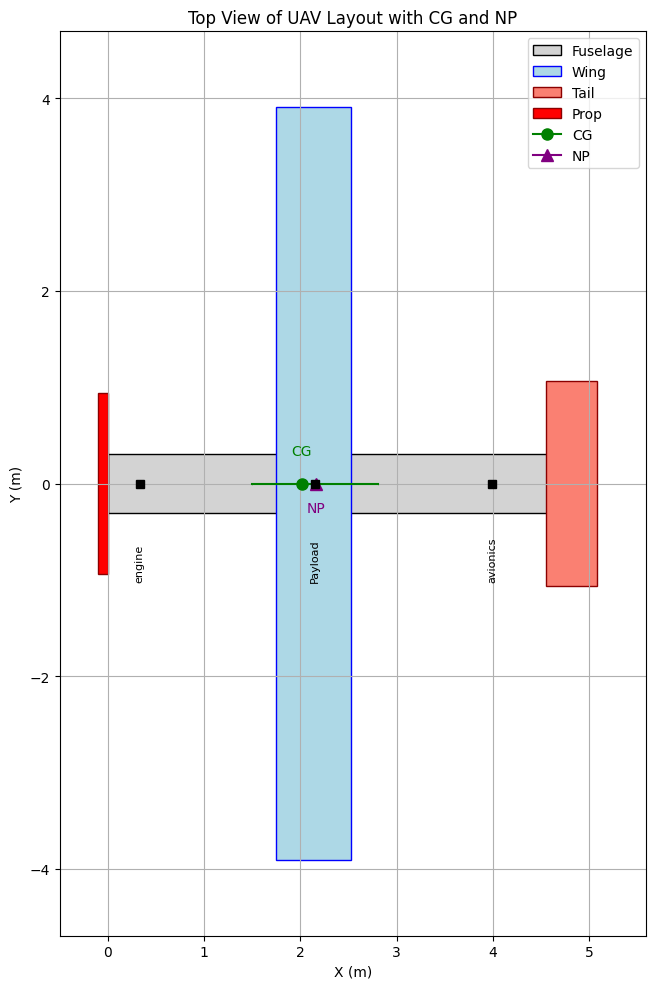

In [30]:


components, components_z = estimate_component_positions(predrop, hard_constraints, assumed_and_set, weights_dict_kg_no_fuel)

components = {"engine":components["engine"], "Payload":components["internal_payload"], "avionics":components["avionics"]}#, "wing_payload": components["wing_payload"]}

# components = {}

# h_tail_le_position = predrop["cruiseout_cg_from_nose_m"] + predrop["tail_arm_m"] - 0.25 * predrop["h_tail_chord_m"]
h_tail_le_position = predrop["wing_le_position_m"] + 0.25* predrop["chord_m"] + predrop["tail_arm_m"] - 0.25 * predrop["h_tail_chord_m"]
# h_tail_le_position = predrop["x_ht_le_m"]
# h_tail_le_position = predrop["wing_le_position_m"] + 0.25* predrop["chord_m"] + predrop["tail_arm_m"] - 0.25 * predrop["h_tail_chord_m"]

plot_uav_top_view(
    fuselage_length=predrop["fuselage_body_length_m"],
    fuselage_width=predrop["fuselage_body_width_m"],
    wing_span=predrop["wing_span_m"],
    wing_chord=predrop["chord_m"],
    wing_le_position=predrop["wing_le_position_m"],
    tail_span=predrop["h_tail_span_m"],
    tail_chord=predrop["h_tail_chord_m"],
    tail_le_position=h_tail_le_position,
    components=components,
    cg_position=predrop["cruiseback_cg_from_nose_m"],
    np_position=predrop["neutral_point_m"],
)



In [13]:
baseline_eval = evaluate_fuel_variant_with_to(
    predrop,             # current_values dictionary (cur)
    assumed_and_set,
    hard_constraints,
    weights_dict_kg_no_fuel,
    deflections_dict,
)

In [22]:
baseline_eval.keys()

dict_keys(['fuel_capacity_kg', 'fuel_loaded_kg', 'fuel_capped', 'tank_capacity', 'takeoff', 'phase', 'mission_times_hr', 'post_mission_fuel_kg', 'max_endurance_loiter_hr', 'max_range_cruise_km', 'power_caps'])